### Visualize DRW Likelihood Surface

<br>**Author(s):** Weixiang Yu 
<br>**Last run:** 07-30-20
<br>**Short description:** This notebook will try to examine the likelihood surface for DRW light curves as a function of LC/$\tau$ ratio. 

In [2]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

# see if local stores mpl style, else use from src
try:
    plt.style.use('yu_basic')
except:
    mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
                '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

pd.set_option('display.max_columns', 999)
%matplotlib inline

In [3]:
# import CARMA celerite term
from agntk.carma.CARMATerm import *
from agntk.lc.utils import *
from agntk.viz.mpl_viz import *
from celerite import GP
from scipy.optimize import minimize

### 1. Simulate LCs with different LC/$\tau$ ratios

In [6]:
t10yr = np.linspace(0,3650, 100000)
yerr10yr = np.random.normal(0, 1e-7, 100000)
tArr = np.empty((5, 100))
yerrArr = np.empty_like(tArr)
yArr = np.empty_like(tArr)
scales = [1,2,5,10,15]

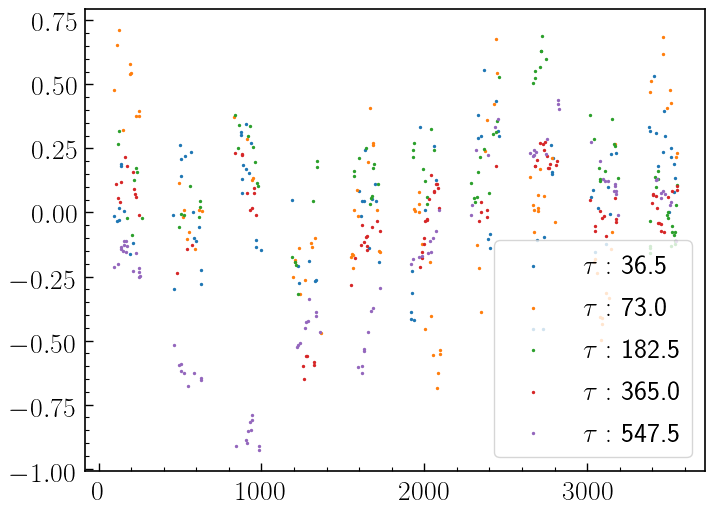

In [9]:
# simulate a series of LCs with different LC/tau ratios
for i, scale in enumerate(scales):
    mask1 = add_season(t10yr)
    mask2 = downsample_byN(t10yr[mask1], 100)

    t = t10yr[mask1][mask2]
    yerr = yerr10yr[mask1][mask2]

    # init GP model and sim LC
    kernel = DRW_term(np.log(0.25), np.log(36.5*scale))
    gp = GP(kernel)
    gp.compute(t, yerr)
    y = gp.sample()

    # write LC to array
    tArr[i, :] = t
    yerrArr[i, :] = yerr
    yArr[i, :] = y


# try plotting
fig = plt.figure(figsize=(8, 6))
for i, scale in enumerate(scales):
    plt.scatter(tArr[i,:], yArr[i, :], s=2, label=f'$\\tau:$ {scale*36.5}')
plt.legend()

### 2. Find best-fit params and plot the likelihood surface

In [16]:
def neg_log_like(params, y, yerr, gp):
    params = np.array(params)
    # pure likelihood based
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

vec_neg_log_like = np.vectorize(neg_log_like, excluded=[1,2,3], signature='(n)->()')

In [11]:
def fitDRW(t, y, yerr, prob_func):
    # check dimention dismatch
    assert (len(t) == len(yerr)) & (len(t) == len(y)), 'Data dimension dismatch.'
    
    ## start fitting
    # initialize parameter in the possible range
    init_tau = np.exp(np.random.uniform(1, np.log(700), 1)[0])
    init_amp = np.random.uniform(0, 0.35, 1)[0]

    kernel_fit = DRW_term(np.log(init_amp), np.log(init_tau))
    gp_fit = GP(kernel_fit)
    gp_fit.compute(t, yerr)

    initial_params = gp_fit.get_parameter_vector()
    bounds = gp_fit.get_parameter_bounds()

    r = minimize(prob_func, initial_params, method="L-BFGS-B", bounds=bounds, \
                 args=(y, yerr, gp_fit))
    
    return r.x

In [12]:
# generate best-fit params
best_tau = []
best_amp = []

for i in range(len(scales)):
    best_params = fitDRW(tArr[i,:], yArr[i,:], yerrArr[i,:], neg_log_like)
    best_params = np.exp(best_params)
    best_tau.append(best_params[1])
    best_amp.append(best_params[0])

LC/tau ratio: 100.0
LC/tau ratio: 50.0
LC/tau ratio: 20.0
LC/tau ratio: 10.0
LC/tau ratio: 6.666666666666667


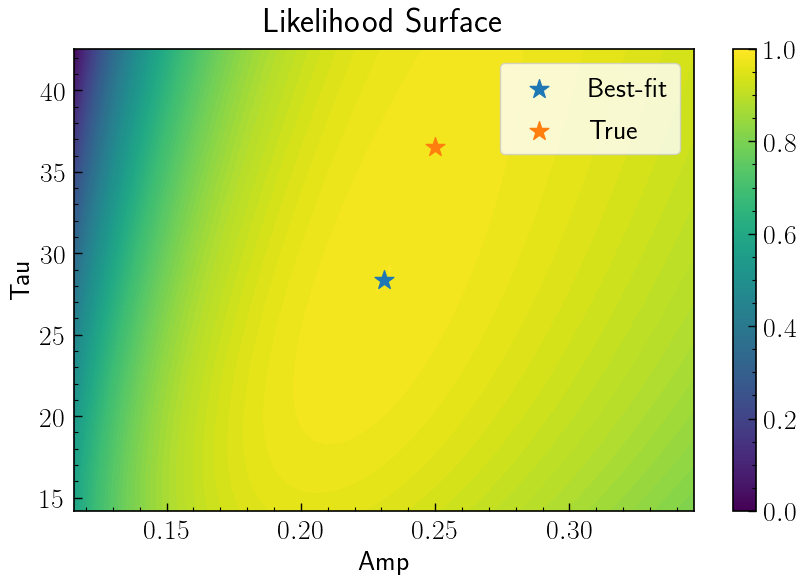

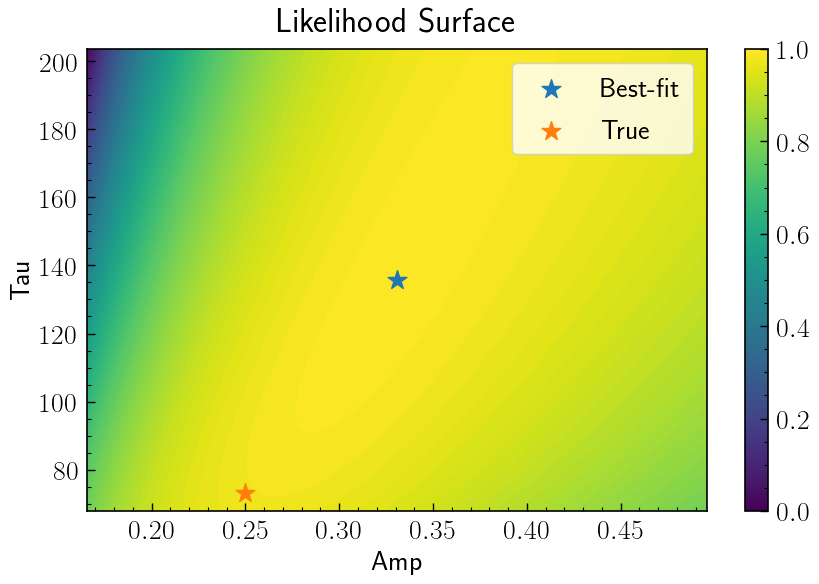

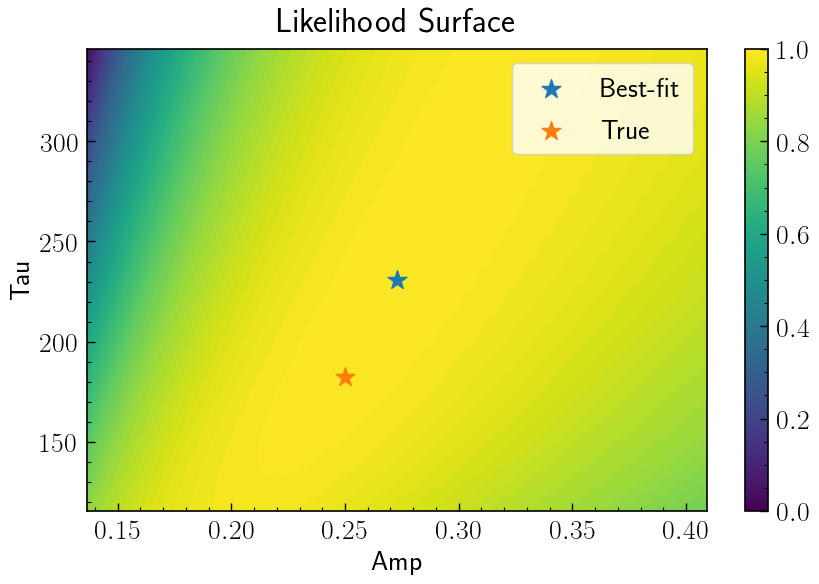

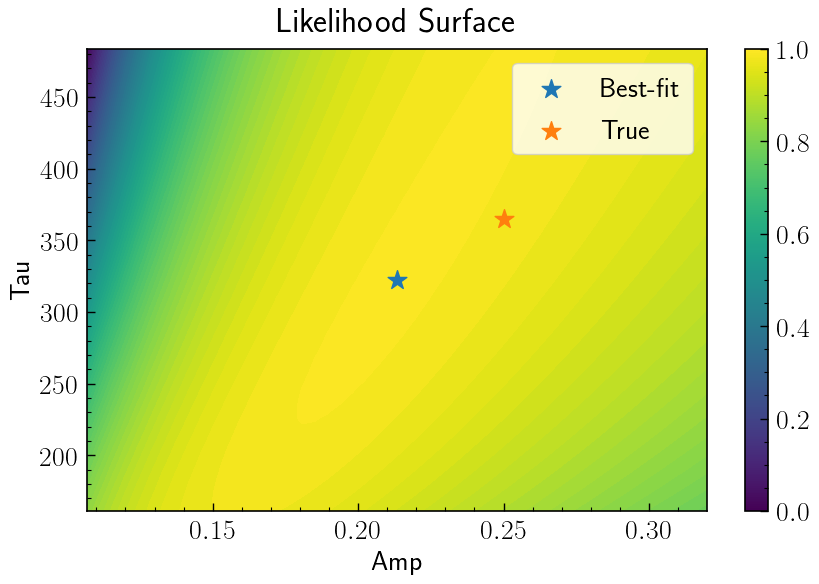

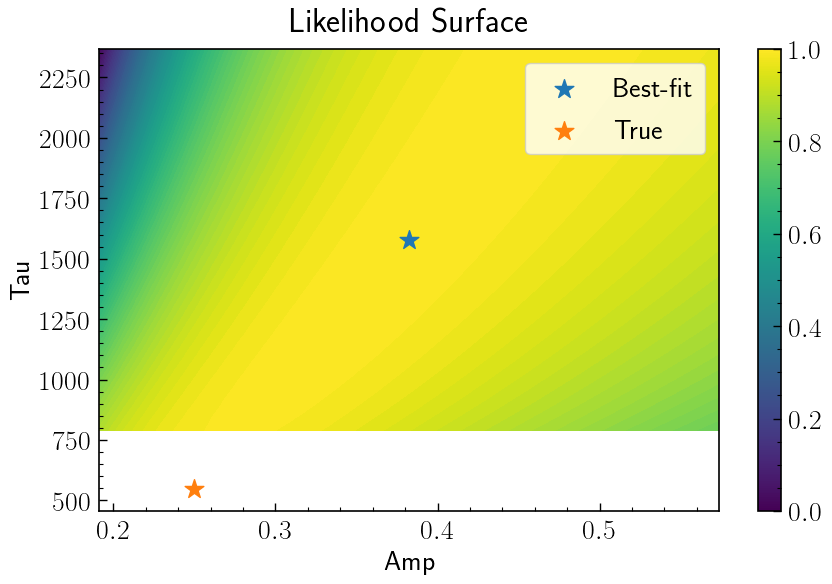

In [19]:
# plot best-fit & true on likelihood surface
init_tau = np.exp(np.random.uniform(1, np.log(700), 1)[0])
init_amp = np.random.uniform(0, 0.35, 1)[0]

kernel_fit = DRW_term(np.log(init_amp), np.log(init_tau))
gp_fit = GP(kernel_fit)

for i, scale in enumerate(scales):
    print(f'LC/tau ratio: {100/scale}')
    plot_drw_ll(tArr[i,:], yArr[i,:], yerrArr[i,:], [best_amp[i], best_tau[i]], \
        gp_fit, vec_neg_log_like, true_params=[0.25, scale*36.5])

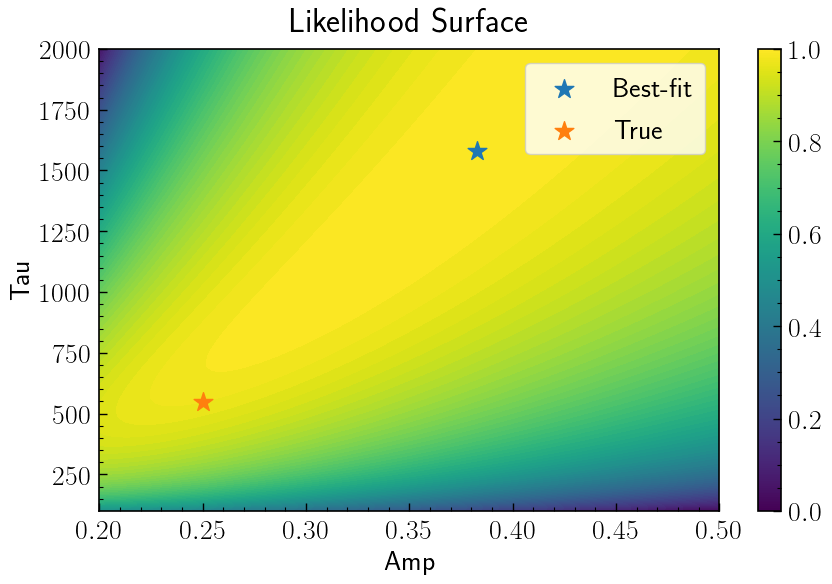

In [21]:
# examine the worst-fit LC with larger param range
i = 4
plot_drw_ll(tArr[i,:], yArr[i,:], yerrArr[i,:], [best_amp[i], best_tau[i]], \
    gp_fit, vec_neg_log_like, amp_range=[0.2, 0.5], tau_range=[100, 2000], \
        grid_size=100, true_params=[0.25, scale*36.5])

<span style='color:red'> __Conclusion:__ </span> From the tests down in this notebook, we can see that for a variaty of LC/$\tau$ ratios, the fitting alogrithm indeed found the 'best solution' given the loss function.